# [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)
*Gatys L. et al., 2015*

This code is a simple passing through the PyTorch neural image style transfer tutorial. 

See: 
* [Neural Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)
* [Neural Style Transfer Tutorial -Part 1](https://towardsdatascience.com/neural-style-transfer-tutorial-part-1-f5cd3315fa7f)

## Utility functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [49]:
# I know that CUDA is available in my PC
device = 'cuda'
imsize = (512, 512)

In [50]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

In [51]:
def load_image(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0) # batch dimensions
    return image.to(device, torch.float)

In [38]:
style_img = load_image("data/vg.jpg")
content_img = load_image("data/tue.jpg")

Functions to transform tensors back and display images

In [39]:
unloader = transforms.ToPILImage()

plt.ion() # Interactive mode on

def imshow(tensor, title = None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

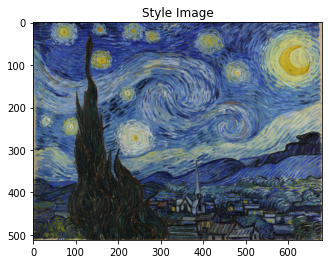

In [40]:
plt.figure()
imshow(style_img, title = 'Style Image')

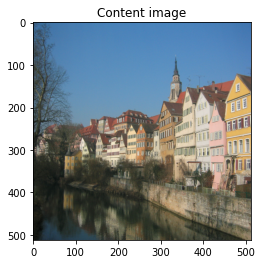

In [14]:
plt.figure()
imshow(content_img, title="Content image")

## Loss functions

### Contents loss

In [15]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # We detach target from the graph, because it's not a variable
        # We don't want to compute gradient for this variable.
        # It would raise an error anyway
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    

> Important detail: although this module is named ContentLoss, it is not a true PyTorch Loss function. If you want to define your content loss as a PyTorch Loss function, you have to create a PyTorch autograd function to recompute/implement the gradient manually in the backward method.

### Gram matrix

Named after [Jørgen Pedersen Gram](https://en.wikipedia.org/wiki/J%C3%B8rgen_Pedersen_Gram). 

See: [Gram matrix](https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_Gram_matrix.html)

$G = X^{T}X$

where $X$ is a specific collection of vectors in the given space.

> Remark *[torch.dot](https://pytorch.org/docs/stable/generated/torch.dot.html)* is only for vectors. For matrices use 
*[torch.mm](https://pytorch.org/docs/stable/generated/torch.mm.html)* or simply *@*. See: [How to do product of matrices in PyTorch](https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch)

In [16]:
# TODO: check difference between
# torch.mm(features, features.t())
# and
# torch.mm(features,t(), features)
# 
# https://inst.eecs.berkeley.edu/~ee127/sp21/livebook/def_Gram_matrix.html
# AtA vs AAt 
# 
# Transforms a tensor to matrix and computes Gram matrix
def gram_matrix(input):
    # a - "batch"
    # b - numper of feature maps
    # c, d - height and width
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    return torch.mm(features, features.t()), a, b, c, d
    
def normalized_gram_matrix(input, gatys = True):
    G, a, b, c, d = gram_matrix(input)
    x, y = G.size()
    if gatys:
        return G / (4 * x ^ 2 * y ^ 2 )
    else:
        return G.div(a * b * c * d)

In [17]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        # Target is constant
        super(StyleLoss, self).__init__()
        self.target = normalized_gram_matrix(target_feature).detach()
    
    def forward(self, input):
        G = normalized_gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing a model

In [18]:
# We can get "features" part of the model at once
# eval() is a net mode
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [19]:
# !pip3 install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [20]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [21]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [22]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

In [23]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [29]:
def prepare_model(cnn, norm_mean, norm_std, 
                 style_img, content_img,
                 content_layers=content_layers_default,
                 style_layers=style_layers_default):
    
    normalization = Normalization(norm_mean, norm_std)
    
    content_losses = []
    style_losses = []
    
    # Normalize input as VGG19 does
    model = nn.Sequential(normalization)
    
    i = 0
    
    
    # cnn only contains 'feature' layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace = False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        # Loss layers are 'transparent', because they return their input
        # without changes: they additionally compute loss
        if name in content_layers:
            target =  model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
     # now we trim off the layers after the last content and style losses
    for last_layer in range(len(model) - 1, -1, -1):
        if isinstance(model[last_layer], ContentLoss) or isinstance(model[last_layer], StyleLoss):
            break

    model = model[:(last_layer + 1)]
    
    return model, style_losses, content_losses
            

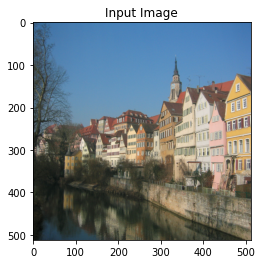

In [30]:
# Copy of the content image or white noise
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

> As Leon Gatys, the author of the algorithm, suggested here, we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [31]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer 

In [32]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = prepare_model(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                # print(vars(sl))
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [33]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..


/tmp/ipykernel_4655/680860454.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_4655/680860454.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 1365536640.000000 Content Loss: 18.404848

run [100]:
Style Loss : 99164936.000000 Content Loss: 19.518070

run [150]:
Style Loss : 28637456.000000 Content Loss: 19.957012

run [200]:
Style Loss : 12481392.000000 Content Loss: 20.212891

run [250]:
Style Loss : 6544871.000000 Content Loss: 20.463552

run [300]:
Style Loss : 3873193.250000 Content Loss: 20.677805



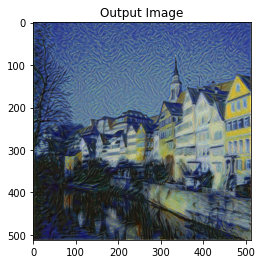

In [34]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
## Custom images

In [80]:
# style_img = load_image("custom-data/mona-lisa.jpg")
# content_img = load_image("custom-data/xxx.jpg")

style_img = load_image("data/vg.jpg")
content_img = load_image("data/tue.jpg")

input_img = content_img.clone()

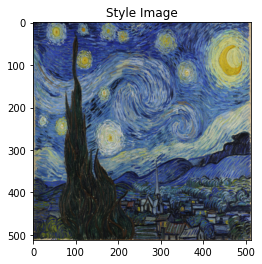

In [81]:
plt.figure()
imshow(style_img, title = 'Style Image')

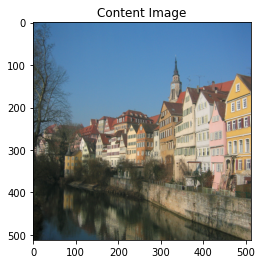

In [82]:
plt.figure()
imshow(content_img, title = 'Content Image')

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            num_steps=1000, style_weight=10, content_weight=100)

Building the style transfer model..
Optimizing..


/tmp/ipykernel_4655/680860454.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_4655/680860454.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 14569.608398 Content Loss: 1762.976807

run [100]:
Style Loss : 1026.801270 Content Loss: 1723.582642

run [150]:
Style Loss : 341.436218 Content Loss: 1497.180054

run [200]:
Style Loss : 186.886292 Content Loss: 1299.200562



In [ ]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()